<a href="https://colab.research.google.com/github/KavindaRajapaksha/Brain-Tumor-Detection2024/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the images

In [ ]:
tumor=[]
path ='/content/drive/MyDrive/dataset/data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
  img=cv2.imread(f)
  img=cv2.resize(img,(128,128))
  b,g,r =cv2.split(img)
  img=cv2.merge([r,g,b])
  tumor.append(img)



In [ ]:
healthy=[]
path ='/content/drive/MyDrive/dataset/data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
  img=cv2.imread(f)
  img=cv2.resize(img,(128,128))
  b,g,r =cv2.split(img)
  img=cv2.merge([r,g,b])
  healthy.append(img)


In [ ]:
len(healthy)

85

In [ ]:
healthy=np.array(healthy)
tumor=np.array(tumor)
All=np.concatenate((healthy,tumor))

In [ ]:
All.shape

(171, 128, 128, 3)

In [ ]:
healthy.shape

(85, 128, 128, 3)

In [ ]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
np.random.choice(5,3)

array([1, 4, 2])

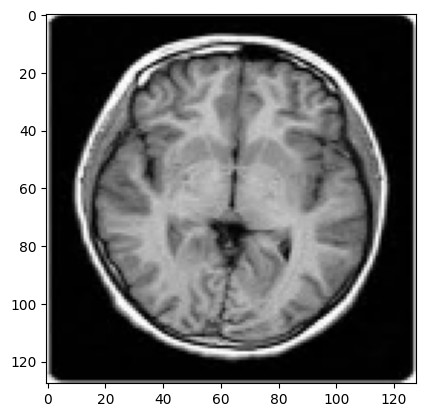

In [ ]:
plt.imshow(healthy[0])

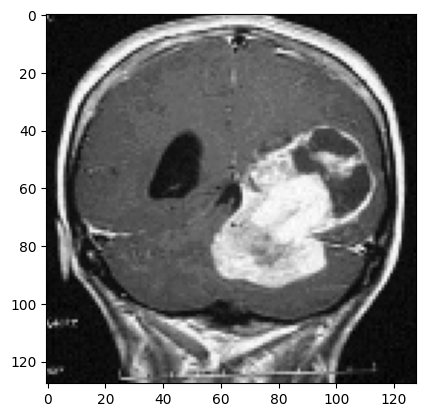

In [ ]:
plt.imshow(tumor[3])